In [61]:
import Dates

import CSV
import DataFrames
import Pandas
import PyCall

using Plots

@PyCall.pyimport pandas
@PyCall.pyimport numpy

mutable struct Limit
    ts::Dates.DateTime
    price::Float64
    volume::Float64
end

mutable struct Orderbook
    bids::Array{Limit, 1}
    asks::Array{Limit, 1}
end

In [180]:
data = CSV.read("gdax_BTC-USDC.csv", header=[:ts, :seq, :is_trade, :is_bid, :price, :volume], types=[Union{i, Missing} for i in [Float64, UInt64, Bool, Bool, Float64, Float64]]);
sort!(data, (:ts));
data[:ts] = Dates.unix2datetime.(data[:ts]);

In [181]:
trades = data[data[:is_trade] .== true, :];
limit_orders = data[data[:is_trade] .== false, :];

In [182]:
function create_orderbook(df::DataFrames.DataFrame, cb::Union{Function, Nothing}=nothing,
                          mut_vector::Union{Array{Any}, Nothing}=nothing, pass_order::Bool=true)::Orderbook
    # Takes in a dataframe with orderbook information.
    # Orderbook information is contained as book deltas with the following headers:
    #     :ts, :seq, :is_trade, :is_bid, :price, :volume
    #
    # Trades will be skipped over.
    #
    # Argument Descriptions
    # `df`: Orderbook deltas with headers [:ts, :seq, :is_trade, :is_bid, :price, :volume]
    #
    # `cb`: Callback function called each delta. The state of the orderbook will be passed
    #       to the callback for computing values. Five arguments are passed into the callback.
    #       In order, they are: f(book::Orderbook, vec::Union{Array{Any}, Nothing}, order::DataFrames.DataFrameRow, ret_value::Bool=false)
    #
    # `mut_vector`: Vector to insert callback result values. Mutates the vector passed to the function.
    #               If a callback is supplied but no vector is passed, the callback is skipped.
    #
    # `ret_ts`: Boolean value that determines whether to pass the current delta/order into the callback.
    #           A side effect of setting this value to `true` is that the `mut_vector` will contain
    #           a timestamp prepended to each value pushed to `mut_vector` as a matrix.
    
    bids = Limit[Limit(Dates.unix2datetime(0), 0.0, 0.0)]
    asks = Limit[Limit(Dates.unix2datetime(0), 0.0, 0.0)]
        
    for order in DataFrames.eachrow(df[df[:is_trade] .== false, :])
        # Determine where to insert the order in the bids/asks vector
        if order[:is_bid]
            # If we have no elements, we will not be able to reach any
            # of the logic in the upcoming for loop. Fix it by inserting
            # a dummy value into the vector       
            for (index, level) in enumerate(bids)
                if level.price == order[:price]
                    if order[:volume] == 0.0
                        # Delete the level if we have a zero sized order
                        deleteat!(bids, index)
                        
                        # Run callback if we have one
                        if cb != nothing && mut_vector != nothing && length(bids) > 1 && length(asks) > 1
                            if pass_order
                                cb(Orderbook(bids[1:length(bids)-1], reverse(asks)[2:length(asks)]), mut_vector, order, false)
                            else
                                cb(Orderbook(bids[1:length(bids)-1], reverse(asks)[2:length(asks)]), mut_vector, nothing, false)
                            end
                        end
                        
                        break
                    end
                    # Update the level if we have a duplicate price level
                    bids[index] = Limit(order[:ts], order[:price], order[:volume])
                    
                    # Run callback if we have one
                    if cb != nothing && mut_vector != nothing && length(bids) > 1 && length(asks) > 1
                        if pass_order
                            cb(Orderbook(bids[1:length(bids)-1], reverse(asks)[2:length(asks)]), mut_vector, order, false)
                        else
                            cb(Orderbook(bids[1:length(bids)-1], reverse(asks)[2:length(asks)]), mut_vector, nothing, false)
                        end
                    end
                    
                    break
                elseif order[:price] > level.price
                    # Don't add if the size is 0
                    if order[:volume] == 0.0
                        break
                    end
                    # For missing orders
                    # Insert one level above encountered price
                    insert!(bids, index, Limit(order[:ts], order[:price], order[:volume]))
                    
                    # Run callback if we have one
                    if cb != nothing && mut_vector != nothing && length(bids) > 1 && length(asks) > 1
                        if pass_order
                            cb(Orderbook(bids[1:length(bids)-1], reverse(asks)[2:length(asks)]), mut_vector, order, false)
                        else
                            cb(Orderbook(bids[1:length(bids)-1], reverse(asks)[2:length(asks)]), mut_vector, nothing, false)
                        end
                    end
                    
                    break
                end
            end
        else
            # If we have no elements, we will not be able to reach any
            # of the logic in the upcoming for loop. Fix it by inserting
            # a first value into the vector
            for (index, level) in enumerate(asks)
                if level.price == order[:price]
                    if order[:volume] == 0.0
                        # Delete the level if we have a zero sized order
                        deleteat!(asks, index)
                        
                        # Run callback if we have one
                        if cb != nothing && mut_vector != nothing && length(bids) > 1 && length(asks) > 1
                            if pass_order
                                cb(Orderbook(bids[1:length(bids)-1], reverse(asks)[2:length(asks)]), mut_vector, order, false)
                            else
                                cb(Orderbook(bids[1:length(bids)-1], reverse(asks)[2:length(asks)]), mut_vector, nothing, false)
                            end
                        end
                        
                        break
                    end
                    # Update the level if we have a duplicate price level
                    asks[index] = Limit(order[:ts], order[:price], order[:volume])
                    
                    # Run callback if we have one
                    if cb != nothing && mut_vector != nothing && length(bids) > 1 && length(asks) > 1
                        if pass_order
                            cb(Orderbook(bids[1:length(bids)-1], reverse(asks)[2:length(asks)]), mut_vector, order, false)
                        else
                            cb(Orderbook(bids[1:length(bids)-1], reverse(asks)[2:length(asks)]), mut_vector, nothing, false)
                        end
                    end
                    
                    break
                    
                elseif order[:price] > level.price
                    # Don't add if the size is 0
                    if order[:volume] == 0.0
                        break
                    end
                    # For missing orders
                    # Insert one level above encountered price
                    insert!(asks, index, Limit(order[:ts], order[:price], order[:volume]))
                    
                    # Run callback if we have one
                    if cb != nothing && mut_vector != nothing && length(bids) > 1 && length(asks) > 1
                        if pass_order
                            cb(Orderbook(bids[1:length(bids)-1], reverse(asks)[2:length(asks)]), mut_vector, order, false)
                        else
                            cb(Orderbook(bids[1:length(bids)-1], reverse(asks)[2:length(asks)]), mut_vector, nothing, false)
                        end
                    end
                    
                    break
                end
            end
        end
    end
    
    return Orderbook(bids[1:length(bids)-1], reverse(asks)[2:length(asks)])
end

@inline function mid_price(book::Orderbook, mut_vector::Union{Array{Any}, Nothing}, 
                           order::Union{DataFrames.DataFrameRow, Nothing}, ret_val::Bool=true)
    # Gets the mid price of the orderbook `book` at time `t`.
    # Mid price is defined as `(best_bid + best_ask) / 2`
    # Pushes Float64 value to mutable vector or 
    # [Dates.DateTime Float64] 1x2 matrix into the mutable vector
    
    mid_price = (book.asks[1].price + book.bids[1].price) / 2
    
    if mut_vector != nothing
        if order == nothing
            push!(mut_vector, mid_price)
        else
            push!(mut_vector, [order.ts mid_price])
        end
    end
    
    if ret_val
        if order == nothing
            return mid_price
        else
            return vcat([order[:ts] mid_price])
        end
    end
end

@inline function spread(book::Orderbook, mut_vector::Union{Array{Any}, Nothing}, 
                        order::Union{DataFrames.DataFrameRow, Nothing}, ret_val::Bool=true)
    # Gets the spread of the orderbook `book` at time `t`.
    # Spread is defined as `best_ask - best_bid`
    # Pushes Float64 value to mutable vector or 
    # [Dates.DateTime Float64] 1x2 matrix into the mutable vector
    spread = book.asks[1].price - book.bids[1].price
    
    if mut_vector != nothing
        if order == nothing
            push!(mut_vector, spread)
        else
            push!(mut_vector, [order[:ts] spread])
        end
    end
    
    if ret_val
        if order == nothing
            return spread
        else
            return vcat([order[:ts] spread]...)
        end
    end
end

@inline function bid_relative_price_level(book::Orderbook, mut_vector::Union{Array{Any}, Nothing},
                                          order::Union{DataFrames.DataFrameRow, Nothing}, ret_val::Bool=true,
                                          level::Int64=1)
    
    if length(book.bids) > level
        if mut_vector != nothing
            if order == nothing
                push!(mut_vector, book.bids[1].price - book.bids[level].price)
            else
                push!(mut_vector, [order[:ts] book.bids[1].price - book.bids[level].price])
            end
        end

        if ret_val
            if order == nothing
                return book.bids[1].price - book.bids[level].price
            else
                return vcat([order[:ts] book.bids[1].price - book.bids[level].price])
            end
        end
    end
end

@inline function bid_relative_price(book::Orderbook, mut_vector::Union{Array{Any}, Nothing},
                                    order::Union{DataFrames.DataFrameRow, Nothing}, ret_val::Bool=true,
                                    price::Float64=1.0)
    
    for (level_index, level) in enumerate(book.bids)
        if level.price == price
            if mut_vector != nothing
                if order == nothing
                    push!(mut_vector, [level_index level.price])
                else
                    push!(mut_vector, [order[:ts] level_index level.price])
                end
            end
            
            if ret_val
                if order == nothing
                    return [level_index level.price]
                else
                    return [order[:ts] level_index level.price]
                end
            end
        
            break
            
        end
        
        if level_index == length(book.bids)
            println("Price $(price) not found in bids")
        end
    end
end

@inline function ask_relative_price(book::Orderbook, mut_vector::Union{Array{Any}, Nothing},
                                    order::Union{DataFrames.DataFrameRow, Nothing}, ret_val::Bool=true,
                                    price::Float64=1.0)
    
    for (level_index, level) in enumerate(book.asks)
        if level.price == price
            if mut_vector != nothing
                if order == nothing
                    push!(mut_vector, [level_index level.price])
                else
                    push!(mut_vector, [order[:ts] level_index level.price])
                end
            end
            
            if ret_val
                if order == nothing
                    return [level_index level.price]
                else
                    return [order[:ts] level_index level.price]
                end
            end
        
            break
            
        end
        
        if level_index == length(book.asks)
            println("Price $(price) not found in asks")
        end
    end
end

@inline function ask_relative_price_level(book::Orderbook, mut_vector::Union{Array{Any}, Nothing},
                                          order::Union{DataFrames.DataFrameRow, Nothing}, ret_val::Bool=true,
                                          level::Int64=1)

    if mut_vector != nothing
        if order == nothing
            push!(mut_vector, book.asks[level].price - book.asks[1].price)
        else
            push!(mut_vector, [order[:ts] book.asks[level].price - book.asks[1].price])
        end
    end
    
    if ret_val
        if order == nothing
            return book.asks[level].price - book.asks[1].price
        else
            return vcat([order[:ts] book.asks[level].price - book.asks[1].price])
        end
    end
end
    
@inline function depth(book::Orderbook, mut_vector::Union{Array{Any}, Nothing}, 
                       order::Union{DataFrames.DataFrameRow, Nothing}=nothing, ret_val::Bool=true)
    
    bid_depth = vcat([[level.ts level.price level.volume] for level in book.bids]...)
    bid_depth[:, 3] = cumsum(bid_depth[:, 3])
    
    ask_depth = vcat([[level.ts level.price level.volume] for level in book.asks]...)
    ask_depth[:, 3] = cumsum(ask_depth[:, 3])

    if mut_vector != nothing
        if order == nothing
            push!(mut_vector, [bid_depth[:, 2:3], ask_depth[:, 2:3]])
        else
            push!(mut_vector, [bid_depth, ask_depth])
        end
    end
    
    if ret_val
        if order == nothing
            return [bid_depth[:, 2:3], ask_depth[:, 2:3]]
        else
            return [bid_depth, ask_depth]
        end
    end
end

function depth_at_level(book::Orderbook, mut_vector::Union{Array{Any}, Nothing}, 
                                order::Union{DataFrames.DataFrameRow, Nothing}, ret_val::Bool=true,
                                level=1, bid=true)
    
    if bid
        if size(book.bids)[1] < level
            return
        end
        
        bid_depth = vcat([[level.ts level.price level.volume] for level in book.bids]...)
        bid_depth[:, 3] = cumsum(bid_depth[:, 3])
        
        if mut_vector != nothing
            if order == nothing
                push!(mut_vector, reshape(bid_depth[level, 2:3], :, 2))
            else
                push!(mut_vector, reshape(bid_depth[level, :], :, 3))
            end
        end
        
        if ret_val
            if order == nothing
                return reshape(bid_depth[level, 2:3], :, 2)
            else 
                return reshape(bid_depth[level, :], :, 3)
            end
        end
    else
        if size(book.asks)[1] < level
            return
        end
        
        ask_depth = vcat([[level.ts level.price level.volume] for level in book.asks]...)
        ask_depth[:, 3] = cumsum(ask_depth[:, 3])
        
        if order == nothing
            push!(mut_vector, reshape(ask_depth[level, 2:3], :, 2))
        else
            push!(mut_vector, reshape(ask_depth[level, :], :, 3))
        end
        
        if ret_val
            if order == nothing
                return reshape(ask_depth[level, 2:3], :, 2)
            else
                return reshape(ask_depth[level, :], :, 3)
            end
        end
    end
end

depth_at_level (generic function with 4 methods)

In [187]:
relative_prices = []
book = create_orderbook(limit_orders, depth, relative_prices)
#book = create_orderbook(limit_orders, (x,y,z,a) -> bid_relative_price_level(x,y,z,a,2), relative_prices);
#relative_prices = vcat(relative_prices...);

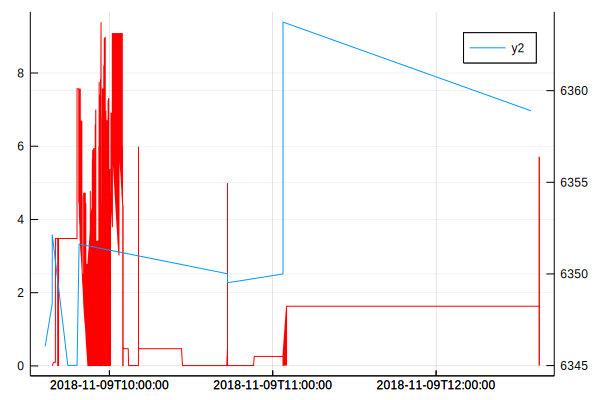

In [185]:
plt = plot()
plot!(plt, relative_prices[:, 1], relative_prices[:, 2], color=:red)
plt_shared = twinx(plt)
plot!(plt_shared, trades[:ts], trades[:price])

In [203]:
anim = @animate for (idx, d) in enumerate(relative_prices[1:1000])
    plot(d[1][:, 2], d[1][:, 3], title="Bid/Ask Depth - Iteration $(idx)", xscale=:log10)
    plot!(d[2][:, 2], d[2][:, 3], xscale=:log10)
end

Animation("/var/folders/lx/_q340spd4ln50dpkg3627g180000gn/T/tmpZ7z9Vg", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000991.png", "000992.png", "000993.png", "000994.png", "000995.png", "000996.png", "000997.png", "000998.png", "000999.png", "001000.png"])

In [204]:
gif(anim, fps = 60)

┌ Info: Saved animation to 
│   fn = /Users/gerardosalazar/Documents/Projects/CuteQ/cinnamon_roll/tmp.gif
└ @ Plots /Users/gerardosalazar/.julia/packages/Plots/rmogG/src/animation.jl:90


Plots.AnimatedGif("/Users/gerardosalazar/Documents/Projects/CuteQ/cinnamon_roll/tmp.gif")